<a href="https://colab.research.google.com/github/jackylmw/Week-2_Data_Preprocessing/blob/Assignment2_JackyLam/JackyLam_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import drive for subsequent applications

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Required libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import soundfile

# Merge EmoDB and RAVDESS

The EMODB dataset includes recordings from ten professional voice artists, equally divided between males and females.  Each artist in this dataset expresses seven different emotions.  Similarly, the RAVDESS dataset contains recordings from 24 professional actors, showcasing eight distinct emotional expressions.  Although both datasets include similar types of recordings, EmoDB and RAVDESS each use a completely different system for naming their files.  The challenge I encountered was to seamlessly integrate the EMODB recordings into the RAVDESS collection, for which I adjusted the naming scheme of the EMODB files to align with RAVDESS's system.


The actor's ID in EmoDB dataset will be represented using the representation in the RAVDESS dataset

In [3]:
actor_id = {
    "03": "25",
    "08": "26",
    "10": "27",
    "09": "28",
    "11": "29",
    "13": "30",
    "12": "31",
    "14": "32",
    "15": "33",
    "16": "34",
}

Since the emotion categories in the EmoDB dataset are not exactly consistent with those in the RAVDESS dataset, I think bored in EmoDB is calm in RAVDESS. Since the EmoDB does not contain the emotion of surprised, I left it alone, which meant keeping the emotion number of surprised in the original RAVDESS dataset.

In [4]:
emotion = {"W": "05",
           "E": "07",
           "A": "06",
           "F": "03",
           "T": "04",
           "N": "01",
           "L": "02"}

In the EmoDB dataset, different versions are represented by letters, while in RAVDESS, different versions are represented by numbers. To make the EmoDB consistent with RAVDESS naming, I will convert letters to numbers.

In [5]:
versions = {"a": "01", "b": "02", "c": "03", "d": "04", "e": "05", "f": "06"}

Renaming every file in the EmoDB dataset is a tedious step. Completing this task manually would be a daunting and tedious endeavor. Therefore, I developed a Python script to speed up the process. This script will rename each file in the EmoDB dataset. If no RAVDESS folder exists in the same location as the EmoDB folder, a new RAVDESS directory will be generated. If there is already a RAVDESS folder, there is no need to regenerate and overwrite the original folder. Executing this script directly renames the files in the EmoDB folder and transfers them to the RAVDESS folder.

In [6]:
import os

os.chdir(os.path.dirname("/content/drive/MyDrive/IAT481-Assignment2/wav"))

if not os.path.exists("./RAVDESS"):
    os.mkdir("./RAVDESS")

files = os.listdir("./wav")

for f in files:
    new_f = (
        "03-01-"
        + emotion[f[5]]
        + "-01-"
        + f[2:5]
        + "-"
        + versions[f[6]]
        + "-"
        + actor_id[f[0:2]]
        + ".wav"
    )

    if not os.path.exists("./RAVDESS/Actor_" + actor_id[f[0:2]]):
        os.mkdir("./RAVDESS/Actor_" + actor_id[f[0:2]])


    os.rename("./wav/" + f, "./RAVDESS/Actor_" + actor_id[f[0:2]] + "/" + new_f)

# Data Analysis

In this section, we need to visualize our combined dataset and compare the graphs and results of RAVDESS dataset before and after the merger.



Since what we need to compare and analyze is the gender balance and emotion category balance of the dataset before and after the merge, I only need to look at the representation of the emotion and actor ID in the dataset file name separately.

**Load the Dataset and Compute Features**

We have to understand the labelling of the RAVDESS dataset to find the ground truth emotion for each sample. Each file is labelled with 7 numbers delimited by a "-". Most of the numbers describe metadata about the audio samples such as their format (video and/or audio), whether the audio is a song or statement, which of two statements is being read and by which actor.


We're going to define a dictionary based on the third number (emotion) and assign an emotion to each number as specified by the RAVDESS dataset:

In [7]:
#Emotions in the RAVDESS dataset
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

First, I first load the RAVDESS only dataset and look for gender balance and emotion category balance in all audio files under this dataset.



In [13]:
import os, glob

def ravdess_only():
  a, b, c = [], [], []
  count = 0

  for file in glob.glob("/content/drive/MyDrive/IAT481-Assignment2/RAVDESS_ONLY/Actor_*/*.wav"):
    file_name=os.path.basename(file)
    ravdess_actor= file_name.split("-")[6]
    ravdess_actor= list(ravdess_actor)[0:2]
    ravdess_actor= ''.join(ravdess_actor)

    # Get gender of each actor
    if (int(ravdess_actor) % 2) != 0:
            # Odd values are males
            ravdess_gender='Male'
    else:
            # Even values are females
            ravdess_gender='Female'

    # Get the emotion
    ravdess_emotion=file_name.split("-")[2]

    # Change the emotion name to follow RAVDESS
    ravdess_emotion=emotions[ravdess_emotion]

    a.append(ravdess_actor)
    b.append(ravdess_gender)
    c.append(ravdess_emotion)

  return np.array(a), np.array(b), np.array(c)

In [14]:
ravdess_actor, ravdess_gender, ravdess_emotion = ravdess_only()

Generate a matrix of all the audio files in the RAVDESS_ONLY dataset by which actor is speaking in which mood, and determine whether the actor is male or female by the actor's ID.

In [15]:
ravdess_dataframe = pd.DataFrame({'actor':ravdess_actor, 'gender': ravdess_gender, 'emotion': ravdess_emotion})
ravdess_dataframe

,actor,gender,emotion
0,13,Male,fearful
1,13,Male,disgust
2,13,Male,happy
3,13,Male,disgust
4,13,Male,fearful
...,...,...,...
1445,18,Female,angry
1446,18,Female,disgust
1447,18,Female,surprised
1448,18,Female,surprised


Generate a bar chart of the total amount of audio files read by female actors and read by male actors in RAVDESS ONLY dataset.

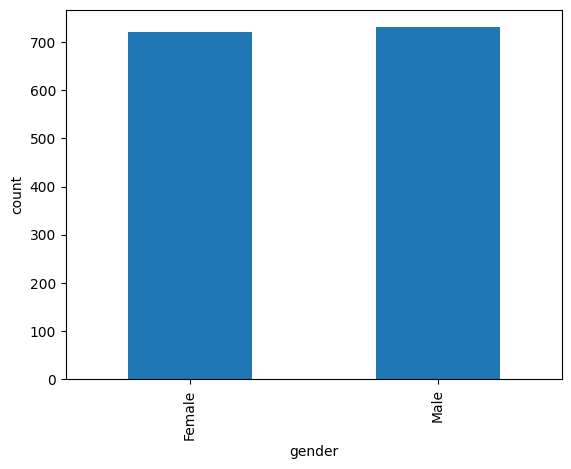

In [19]:
ravdess_dataframe.groupby('gender').size().plot(kind='bar', stacked=True)
plt.ylabel('count')
plt.show()

From the chart, we can see that in RAVDESS ONLY dataset, the total amount of audio files read by female and audio files read by male is very close, a total of 1450 files, about 720 audio files read by female, and about 730 files read by male. It can be seen that, The files read by male only slightly outnumber the audio files read by female in total.

Generate a bar chart of the total amount of audio files read in different emotions in RAVDESS ONLY dataset.

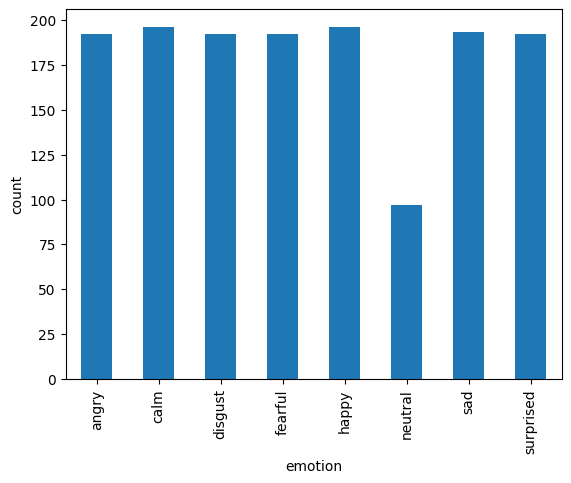

In [20]:
ravdess_dataframe.groupby('emotion').size().plot(kind='bar')
plt.ylabel('count')
plt.show()

From the chart, we can find that in the RAVDESS ONLY dataset, except for the neutral emotion audio files, the amount of audio is only about 100, and the total amount of audio of the other seven emotions is relatively average, about 190-200.

Then, I load the merged RAVDESS dataset and look for gender balance and emotion category balance in all audio files under this dataset.

In [21]:
import os, glob

def merged_ravdess():
  a, b, c = [], [], []
  count = 0

  for file in glob.glob("/content/drive/MyDrive/IAT481-Assignment2/RAVDESS/Actor_*/*.wav"):
    file_name=os.path.basename(file)
    ravdess_actor= file_name.split("-")[6]
    ravdess_actor= list(ravdess_actor)[0:2]
    ravdess_actor= ''.join(ravdess_actor)

    # Get gender of each actor
    if (int(ravdess_actor) % 2) != 0:
            # Odd values are males
            ravdess_gender='Male'
    else:
            # Even values are females
            ravdess_gender='Female'

    # Get the emotion
    ravdess_emotion=file_name.split("-")[2]

    # Change the emotion name to follow RAVDESS
    ravdess_emotion=emotions[ravdess_emotion]

    a.append(ravdess_actor)
    b.append(ravdess_gender)
    c.append(ravdess_emotion)

  return np.array(a), np.array(b), np.array(c)

In [22]:
ravdess_actor, ravdess_gender, ravdess_emotion = merged_ravdess()

Generate a matrix of all the audio files in the merged RAVDESS dataset by which actor is speaking in which mood, and determine whether the actor is male or female by the actor's ID.

In [23]:
ravdess_dataframe = pd.DataFrame({'actor':ravdess_actor, 'gender': ravdess_gender, 'emotion': ravdess_emotion})
ravdess_dataframe

,actor,gender,emotion
0,08,Female,calm
1,08,Female,angry
2,08,Female,sad
3,08,Female,fearful
4,08,Female,fearful
...,...,...,...
1970,27,Male,happy
1971,27,Male,angry
1972,27,Male,neutral
1973,27,Male,neutral


Generate a bar chart of the total amount of audio files read by female actors and read by male actors in merged RAVDESS dataset.

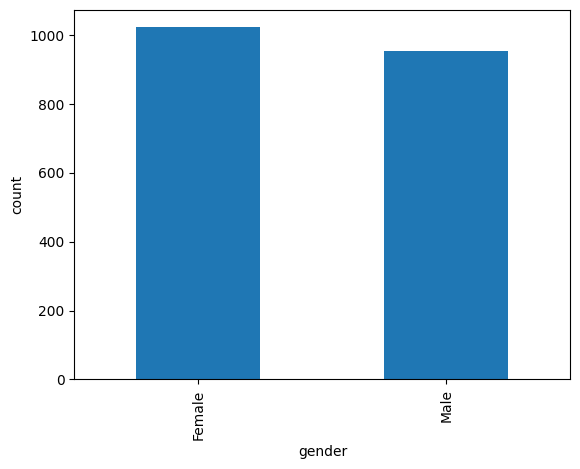

In [24]:
ravdess_dataframe.groupby('gender').size().plot(kind='bar', stacked=True)
plt.ylabel('count')
plt.show()

From the chart, we can see that in the combined RAVDESS data set, the total amount of audio files read by female and male is also relatively similar, with a total of 1,975 files, about 1,020 audio files read by female and about 950 audio files read by male. As we can see, the total amount of files read by female is slightly higher than the total amount of audio files read by male.

Generate a bar chart of the total amount of audio files read in different emotions in merged RAVDESS dataset.

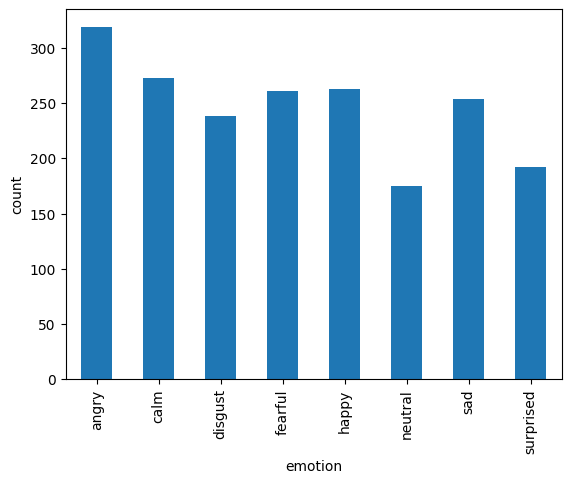

In [25]:
ravdess_dataframe.groupby('emotion').size().plot(kind='bar')
plt.ylabel('count')
plt.show()

From the chart, we can find that in the combined RAVDESS dataset, the amount of audio files for different emotions varies greatly, among which the amount of angry audio files is the largest, more than 300, while the amount of neutral and surprised audio files is the least, both less than 200, and the amount of audio files for other emotions is about 250.